In [151]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [152]:
import numpy as np
import pandas as pd

In [153]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [154]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [155]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [156]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [157]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [158]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [159]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [160]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [161]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [162]:
# Perform a query to retrieve the date and precipitation scores
year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23')

# Save the query results as a Pandas DataFrame and set the index to the date column
one_year = pd.DataFrame(year, columns=['date','precipitation'])
one_year['precipitation'] = one_year['precipitation'].astype(float)
one_year.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [163]:
# Sort the dataframe by date
one_year = one_year.sort_values(['date'])
one_year = one_year.fillna('0')
one_year.head()

,date,precipitation
0,2016-08-23,0
1009,2016-08-23,0
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


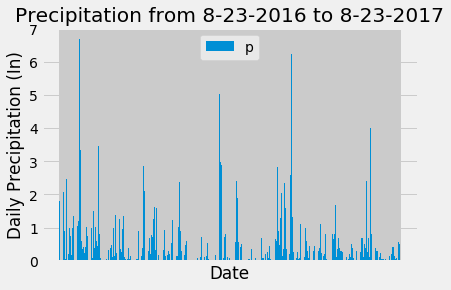

In [164]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(one_year.date, one_year.precipitation.astype(float))
plt.title('Precipitation from 8-23-2016 to 8-23-2017')
plt.xlabel('Date')
plt.ylabel('Daily Precipitation (In)')
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.legend(labels = 'precipitation', loc = 'upper center')
plt.savefig('precip_one_year.png')
plt.show()

![precipitation](Images/precipitation.png)

In [165]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year['precipitation'] = one_year['precipitation'].astype(float)
one_year.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [166]:
# Design a query to show how many stations are available in this dataset?
count = engine.execute('select count(station) from station')
for item in count:
    print(item)

(9,)


In [167]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
data = pd.read_sql("SELECT * FROM measurement", engine)
data1 = data.station.value_counts()
data1

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [168]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_busy = pd.read_sql("select tobs from measurement where station = 'USC00519281'", engine)
print(f"Highest observed temp.: {most_busy.tobs.max()}")
print(f"Lowest observed temp.: {most_busy.tobs.min()}")
print(f"Average observed temp.: {round(most_busy.tobs.mean(),1)}")

Highest observed temp.: 85.0
Lowest observed temp.: 54.0
Average observed temp.: 71.7


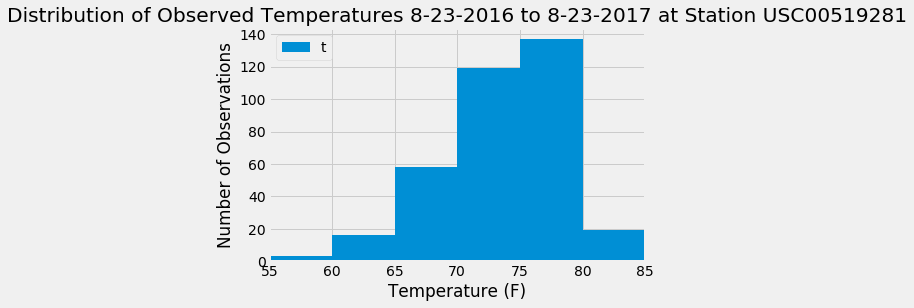

In [170]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year = pd.read_sql("select * from measurement where station = 'USC00519281' and date >= '2016-08-23' and\
 date <= '2017-08-23'", engine) 

plt.hist(year.tobs, bins = [55,60,65,70,75,80,85,90])
plt.xlim(55,85)
plt.title("Distribution of Observed Temperatures 8-23-2016 to 8-23-2017 at Station USC00519281")
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Observations')
plt.legend(labels = 'tobs', loc = 'upper left')
plt.savefig('tobs_one_year.png')
plt.show()

In [171]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date): 
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [172]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-01-23','2017-02-23')

[(59.0, 70.01470588235294, 80.0)]

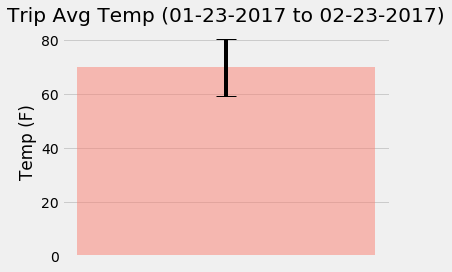

In [173]:
# Plot the results from your previous query as a bar chart. 
x_pos = 0
mean = 70.01470588
# Max - Min = 21, split in half for st.error bars
error = 10.5

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean, yerr=error, align='center', alpha=0.5, color = 'salmon',ecolor='black', capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp (01-23-2017 to 02-23-2017)')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.tight_layout()
plt.savefig('vacation_avg_temp.png')
plt.show()

In [174]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = pd.read_sql("select sum(measurement.prcp), measurement.station, station.name, \
station.latitude, station.longitude, station.elevation from measurement join station on \
station.station = measurement.station where measurement.date >= '2017-01-23' and measurement.date <= '2017-02-23'\
group by measurement.station order by measurement.prcp desc", engine)

rainfall

,sum(measurement.prcp),station,name,latitude,longitude,elevation
0,11.07,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,8.66,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,8.46,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,7.86,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,3.90,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,0.22,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,6.04,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


## Optional Challenge Assignment

In [175]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [176]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
start_date = '2017-01-23'
end_date = '2017-02-23'
# Use the start and end date to create a range of dates
t_dates = pd.to_datetime(np.arange(start_date,end_date, dtype='datetime64'))

# Loop through the list of %m-%d strings and calculate the normals for each date
tr_dates = []
for date in t_dates:
    tr_dates.append(dt.datetime.strftime(date, "%m-%d"))

# Stip off the year and save a list of %m-%d strings
normals = []
for date in tr_dates:
    normals.append(daily_normals(date))
normals

[[(57.0, 69.50909090909092, 79.0)],
 [(58.0, 68.76271186440678, 78.0)],
 [(61.0, 67.94915254237289, 75.0)],
 [(61.0, 70.58620689655173, 77.0)],
 [(59.0, 68.56896551724138, 75.0)],
 [(62.0, 69.03703703703704, 77.0)],
 [(64.0, 69.14, 76.0)],
 [(60.0, 67.12962962962963, 77.0)],
 [(60.0, 68.47368421052632, 74.0)],
 [(56.0, 68.14035087719299, 78.0)],
 [(59.0, 68.85964912280701, 77.0)],
 [(58.0, 67.79661016949153, 77.0)],
 [(61.0, 68.14035087719299, 76.0)],
 [(59.0, 69.6842105263158, 80.0)],
 [(58.0, 70.38983050847457, 77.0)],
 [(60.0, 69.0, 77.0)],
 [(56.0, 66.75438596491227, 74.0)],
 [(57.0, 67.58928571428571, 75.0)],
 [(56.0, 68.41666666666667, 76.0)],
 [(61.0, 69.25, 79.0)],
 [(60.0, 69.15789473684211, 78.0)],
 [(58.0, 70.36206896551724, 80.0)],
 [(62.0, 70.89473684210526, 79.0)],
 [(56.0, 70.28813559322033, 79.0)],
 [(59.0, 70.48214285714286, 76.0)],
 [(62.0, 70.47272727272727, 77.0)],
 [(63.0, 70.79629629629629, 77.0)],
 [(60.0, 69.33962264150944, 77.0)],
 [(63.0, 70.14035087719299, 76

In [177]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
min_temp = []
avg_temp = []
max_temp = []

for row in normals:
    min_temp.append(row[0][0])
    avg_temp.append(row[0][1])
    max_temp.append(row[0][2])

norms = pd.DataFrame({'date':tr_dates, 'Min_Temp':min_temp, 'Avg_Temp':avg_temp, 'Max_Temp':max_temp})
norms = norms.set_index(['date'])
norms.head()

,Min_Temp,Avg_Temp,Max_Temp
date,,,
01-23,57.0,69.509091,79.0
01-24,58.0,68.762712,78.0
01-25,61.0,67.949153,75.0
01-26,61.0,70.586207,77.0
01-27,59.0,68.568966,75.0


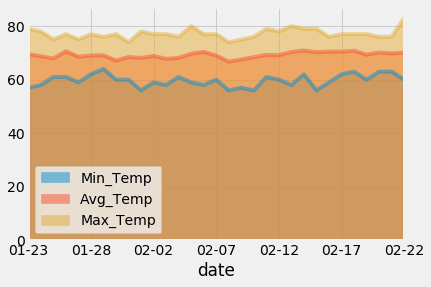

In [178]:
# Plot the daily normals as an area plot with `stacked=False`
norms.plot.area(stacked = False)
plt.savefig('vacation_dailys.png')